In [1]:
%matplotlib inline


Demonstration of load_confounds
============================================



## Background

This notebook is a fork of the <a href="https://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py" target="_blank">"Extracting signals from a brain parcellation"</a> example from Nilearn. From their description: 

> *Here we show how to extract signals from a brain parcellation and compute a correlation matrix.*
> *We also show the importance of **defining good confounds** signals: the first correlation matrix is computed after regressing out simple confounds signals: movement regressors, white matter and CSF signals, ... The second one is without any confounds: all regions are connected to each other.* [Bolded emphasis added]

The data generated by fMRIprep is minimally preprocessed by default. As the Nilearn example demonstrates, only by regressing out confounds are the data made interpretable. 

An issue faced in the literature is how to define good confounds or nuisance variables in a principled and reproducible manner. Preprocessing pipelines such as fMRIPrep may generate a large number of potential confound regressors (100+), with the available regressors depending on initial settings (see <a href="https://fmriprep.org/en/stable/usage.html" target="_blank">"Specific options for estimating confounds"</a>) and variance explained (e.g., CompCor by default includes components that explain 50% of BOLD variance). 

Importantly, it is left to the user to select some combination of confound variables to fully preprocess the time series through denoising (i.e., from the regressors available in the confounds TSV file). There is <a href="https://fmriprep.org/en/stable/outputs.html#confounds" target="_blank">detailed documentation in fMRIPrep</a> about the available confounds and the implications of selecting them, but users are left to (1) decide upon a denoising strategy and (2) implement it by selecting the relevant confounds for regressing out. There can be major repercussions for choosing an inappropriate strategy—note the number of "danger" and "caution" boxes in the aforementioned fMRIPrep documentation on confounds!

The `load_confounds` package addresses those issues by allowing users to choose from predefined and/or flexible strategies, at which point it will automatically select the relevant subset of regressors from the TSV file of all available regressors. If the relevant regressors are not available, the user will be notified. 
- Predefined: The predefined strategies are adapted from <a href="https://doi.org/10.1016/j.neuroimage.2017.03.020">Ciric et al. 2017</a>, and a current list can be viewed on the <a href="https://github.com/SIMEXP/load_confounds#predefined-denoising-strategies" target="_blank">project Github</a>. For example, the predefined strategy `Params9` will select the basic motion parameters, WM/CSF signals, global signal and high pass filter.
- Flexible: Users can also build a strategy from flexible categories, with a current list available on the <a href="https://github.com/SIMEXP/load_confounds#flexible-denoising-strategy" target="_blank">project Github</a>. For example, the flexible strategy `motion` will select the motion parameters including 6 translation/rotation. Optionally, users can include their derivatives, squares, and squared derivatives. 


## Installation


In [2]:
# install via pip with silent output (unless errors)
!pip install load_confounds > /dev/null

## Retrieve the atlas and the data

In [3]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of brain development fmri data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=False)
fmri_filenames = data.func[0]


Dataset created in /root/nilearn_data/fsl



Downloaded 23150592 of 25716861 bytes (90.0%,    0.1s remaining) ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/f46ad01e95960216e8befa3b5c1ed654/HarvardOxford.tgz..... done.


Atlas ROIs are located in nifti image (4D) at: /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz

Dataset created in /root/nilearn_data/development_fmri


Dataset created in /root/nilearn_data/development_fmri/development_fmri



 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


## Load confounds from file using a predefined strategy (more automatic)

When given the path to the fMRI filename, the predefined strategies in `load_confounds` will auto-detect the companion TSV file as long as it resides in the same directory.

The predefined strategies are all adapted from Ciric et al. 2017, and currently include:

-    `Params2` : Mean white matter and CSF signals, with high-pass filter.
-    `Params6` : Basic motion parameters with high pass filter.
-    `Params9` : Basic motion parameters, WM/CSF signals, global signal and high pass filter.
-    `Params24` : Full motion parameters (derivatives, squares and squared derivatives), with high pass filter.
-    `Params36` : Motion parameters, WM/CSF signals, global signal, high pass filter. All noise components are fully expanded (derivatives, squares and squared derivatives).
-    `AnatCompCor` : Motion parameters (fully expanded), high pass filter, and acompcor.
-    `TempCompCor` : High pass filter, and tcompcor.

For this example we will choose `Params9`

In [4]:
from load_confounds import Params9

confounds_Params9 = Params9().load(fmri_filenames)

print("The shape of the confounds matrix is:", confounds_Params9.shape)

The shape of the confounds matrix is: (168, 13)


## Load confounds from file using a flexible strategy (more manual)

Alternatively, `load_confounds` can be used to create a `Confounds` class with flexible parameters. We can print the docstring of `Confounds` to list the options.

In [5]:
from load_confounds import Confounds

print(Confounds.__doc__)


    Confounds from fmriprep

    Parameters
    ----------
    strategy : list of strings
        The type of noise confounds to include.
        "motion" head motion estimates.
        "high_pass" discrete cosines covering low frequencies.
        "wm_csf" confounds derived from white matter and cerebrospinal fluid.
        "global" confounds derived from the global signal.

    motion : string, optional
        Type of confounds extracted from head motion estimates.
        "basic" translation/rotation (6 parameters)
        "power2" translation/rotation + quadratic terms (12 parameters)
        "derivatives" translation/rotation + derivatives (12 parameters)
        "full" translation/rotation + derivatives + quadratic terms + power2d derivatives (24 parameters)

    n_motion : float
        Number of pca components to keep from head motion estimates.
        If the parameters is strictly comprised between 0 and 1, a principal component
        analysis is applied to the motion par

First we create a `Confounds` class which specifies strategies and optional parameters. Then the `load()` method selects the relevant columns from the TSV file. To replicate the predefined strategy of `Params9` in the previous example, we choose `strategy=["high_pass","motion","wm_csf","global"]` and `motion="basic"`

In [6]:
conf = Confounds(strategy=["high_pass","motion","wm_csf","global"], motion="basic")

confounds_flexible = conf.load(fmri_filenames)

print("The shape of the confounds matrix is:", confounds_flexible.shape)

print("Does this flexible strategy match the Params9 predefined strategy:", 
      (confounds_flexible == confounds_Params9).all())

The shape of the confounds matrix is: (168, 13)
Does this flexible strategy match the Params9 predefined strategy: True


## Extract signals on a parcellation defined by labels

In [7]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(fmri_filenames, confounds=confounds_flexible)

[NiftiLabelsMasker.fit_transform] loading data from /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=array([[ 0.006621, ..., -2.997517],
       ...,
       [-0.020041, ...,  0.542358]]), dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_l

## Compute and display a correlation matrix



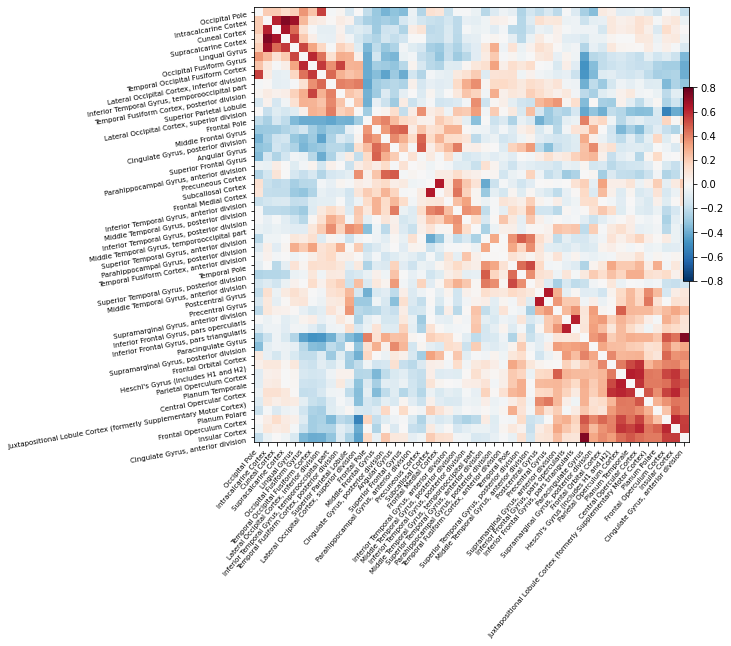

In [8]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

## Same thing without confounds, to stress the importance of confounds

[NiftiLabelsMasker.fit_transform] loading data from /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiLabelsMasker.transform_single_imgs] Loading data from /root/nilearn_data/

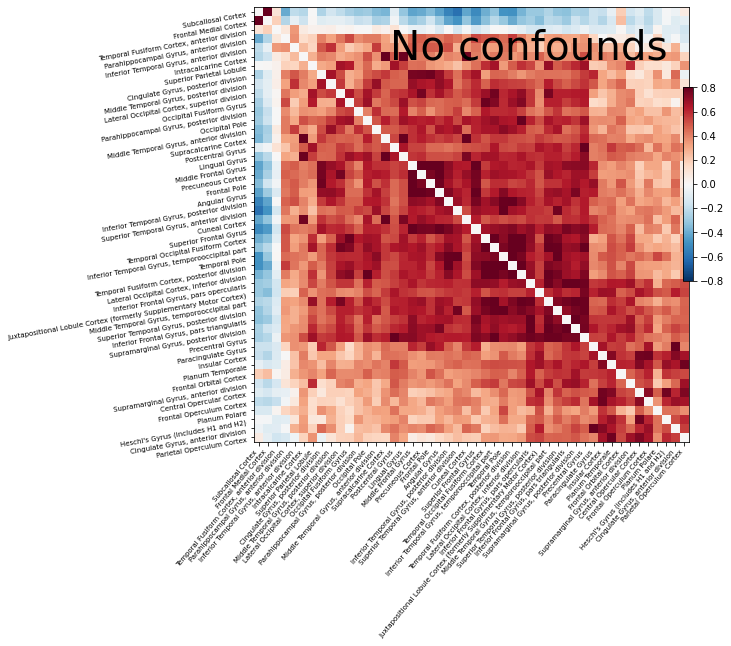

In [9]:
time_series = masker.fit_transform(fmri_filenames)
# Note how we did not specify confounds above. This is bad!

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, title='No confounds', reorder=True)

plotting.show()